#Федотова ПИ20-1В
## Билет 10



## Подготовка данных

.. Примечание::
   Загрузите данные <a href=https://download.pytorch.org/tutorial/data.zip>отсюда</a> и извлеките их в текущую директорию.

В каталог `data/names` включены 18 текстовых файлов с именем `[Language].txt`. Каждый файл содержит кучу имен, по одному имени в строке, в основном латинизированных (но нам все равно нужно преобразовать из Юникода в
ASCII).

В итоге мы получим словарь со списками имен на каждом языке,`{language: [names ...]}`. Общие переменные `category` и `line`(для языка и имени в нашем случае) используются для последующего расширения.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/data.zip" -d "/content/drive/MyDrive/Colab Notebooks/"

In [33]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)
dir_path = "/content/drive/MyDrive/Colab Notebooks/"+'data/names/*.txt'
print(findFiles(dir_path))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(dir_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/MyDrive/Colab Notebooks/data/names/Arabic.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Chinese.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Czech.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Dutch.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/English.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/French.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/German.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Greek.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Irish.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Italian.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Japanese.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Korean.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Polish.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Portuguese.txt', '/content/drive/MyDrive/Colab Notebooks/data/names/Russian.txt', '/content/drive/MyDrive/Colab Not

Теперь у нас есть `category_lines`, словарь, сопоставляющий каждую категорию (язык) со списком строк (имен). Мы также отслеживали `all_categories` (просто список языков) и `n_categories` для последующего использования.

In [34]:
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


Превращение имен в тензоры
--------------------------

Теперь, когда мы упорядочили все имена, нам нужно превратить их в
Тензоры, чтобы как-то их использовать.

Чтобы представить одну букву, мы используем `one-hot` вектор размера
`<1 x n_letters>`. Один горячий вектор заполняется 0, за исключением 1
в индексе текущей буквы, например `"b" = <0 1 0 0 0 ...>`.

Чтобы составить слово, мы объединяем их в 2D-матрицу
`<line_length x 1 x n_letters>`.

Это дополнительное измерение 1 связано с тем, что PyTorch предполагает, что все находится в пакетах - здесь мы просто используем размер пакета 1.

In [35]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Создание сети

Перед вычислением градиентов, создание рекуррентной нейронной сети в Torch включающей
клонирование параметров слоя в течение нескольких временных шагов. Слои
содержали скрытое состояние и градиенты, которые теперь полностью обрабатываются самим
графом. Это означает, что вы можете реализовать RNN очень "чистым" способом,
как обычные слои обратной связи.

Этот модуль RNN (в основном скопирован из учебника <a href=https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net> PyTorch for Torch users tutorial </a>) это всего лишь 2 линейных слоя, которые работают в входном и скрытом состоянии, со слоем LogSoftmax после вывода.

.. рисунок:: https://i.imgur.com/Z2xbySO.png
   :alt:


In [36]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Чтобы запустить шаг этой сети, нам нужно передать входные данные (в нашем случае Тензор для текущей буквы) и предыдущее скрытое состояние (которое мы сначала инициализируем как нули). Мы вернем вывод (вероятность каждого языка) и следующее скрытое состояние (которое мы сохраняем для следующего шага).


In [37]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8377, -2.9388, -2.9288, -2.9599, -2.8639, -3.0365, -2.9351, -2.9656,
         -2.8389, -2.9474, -2.7759, -2.7929, -2.8610, -2.8366, -2.9166, -2.8263,
         -2.9436, -2.8622]], grad_fn=<LogSoftmaxBackward0>)


Для повышения эффективности мы не хотим создавать новый тензор для каждого шага, поэтому мы будем использовать `lineToTensor` вместо `letterToTensor` и использовать срезы. Это может быть дополнительно оптимизировано путем
предварительного вычисления пакетов тензоров.

In [38]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8377, -2.9388, -2.9288, -2.9599, -2.8639, -3.0365, -2.9351, -2.9656,
         -2.8389, -2.9474, -2.7759, -2.7929, -2.8610, -2.8366, -2.9166, -2.8263,
         -2.9436, -2.8622]], grad_fn=<LogSoftmaxBackward0>)


Как вы можете видеть, результат представляет собой тензор `<1 x n_categories>`, где
каждый элемент является вероятностью этой категории (чем выше, тем вероятнее).

## Обучение
Подготовка к обучению
----------------------

Прежде чем приступить к обучению, мы должны сделать несколько вспомогательных функций.
Первый - интерпретировать выходные данные сети, которые, как мы знаем, являются
вероятностью для каждой категории. Мы можем использовать `Tensor.topk`, чтобы получить индекс
наибольшего значения:

In [39]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


Нам также понадобится быстрый способ получить обучающий пример (название и его
язык):

In [40]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Cruz
category = Irish / line = Milligan
category = Russian / line = Nezhdanov
category = Japanese / line = Tomimoto
category = Polish / line = Andrysiak
category = Czech / line = Waclauska
category = German / line = Holzer
category = Spanish / line = Salcedo
category = Chinese / line = She
category = English / line = Mcnaught


# Скорость обучения 0.005

Обучение сети
--------------------

Теперь все, что нужно для обучения этой сети, - это показать ей кучу примеров,
заставить ее строить догадки и сказать, ошибается ли она.

Для функции потерь подходит `nn.NLLLoss`, так как последний слой RNN - `nn.LogSoftmax`.


Скорость обучения 0.005

In [41]:
criterion = nn.NLLLoss()

Каждый цикл обучения будет делать:

- Создание входных и целевых тензоров
- Создание обнуленное начальное скрытое состояние
- Читать каждую букву и

   - Сохранять скрытое состояние для следующего текста

- Сравните конечный результат с целевым
- Обратное распространение
- Возврат выходных данных и значений функции ошибки

In [42]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Теперь нам просто нужно запустить это с кучей примеров. Поскольку функция
`train` возвращает как результат, так и список ошибки, мы можем распечатать ее
предсказание, а также отслеживатьошибку для построения графика. Поскольку существует 1000
примеров, мы печатаем только все примеры `print_every` и берем
среднее значение потерь.

In [43]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.8406 Araujo / Italian ✗ (Portuguese)
10000 10% (0m 14s) 1.7968 Pae / Chinese ✗ (Korean)
15000 15% (0m 20s) 2.3226 Youlden / Dutch ✗ (English)
20000 20% (0m 28s) 1.1887 Reiter / German ✓
25000 25% (0m 36s) 3.5266 Rey / Chinese ✗ (Spanish)
30000 30% (0m 47s) 2.5339 Wildgrube / French ✗ (German)
35000 35% (0m 54s) 0.8993 Lesauvage / French ✓
40000 40% (1m 2s) 0.9419 Henriques / Portuguese ✓
45000 45% (1m 9s) 0.8211 Gibson / Scottish ✓
50000 50% (1m 16s) 0.2395 Nishimoto / Japanese ✓
55000 55% (1m 23s) 0.8238 Jelinek / Czech ✓
60000 60% (1m 31s) 1.9234 Aart / Arabic ✗ (Dutch)
65000 65% (1m 37s) 2.1467 Duguay / Scottish ✗ (French)
70000 70% (1m 45s) 0.3093 Zheng / Chinese ✓
75000 75% (1m 52s) 1.3956 Flynn / Scottish ✗ (Irish)
80000 80% (1m 59s) 2.1551 Peij / Chinese ✗ (Dutch)
85000 85% (2m 6s) 0.8183 Favre / French ✓
90000 90% (2m 14s) 2.4568 Simonis / Greek ✗ (Dutch)
95000 95% (2m 20s) 1.0461 Aritza / Portuguese ✗ (Spanish)
100000 100% (2m 28s) 1.6178 Groel / Arabic ✗ (Ge

Построение графика результатов
--------------------

Построение графика исторических потерь из `all_losses` показывает
обучение сети:

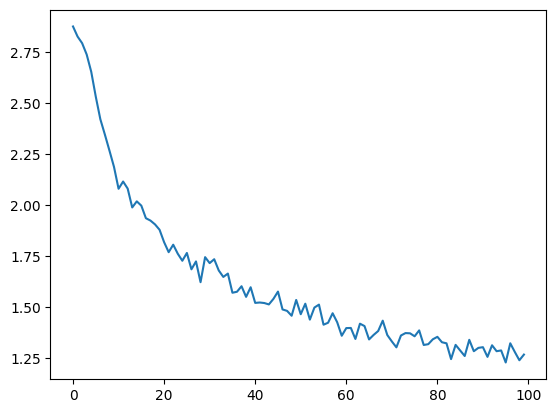

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Оценка результатов

Чтобы увидеть, насколько хорошо сеть работает с различными категориями, мы
создадим матрицу путаницы, указывающую для каждого фактического языка (строк)
какой язык угадывает сеть (столбцы). Чтобы рассчитать матрицу путаницы
, по сети выполняется множество выборок с
`evaluate()`, что то же самое, что `train()` за вычетом обратного распространения ошибки.


<ipython-input-45-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-45-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


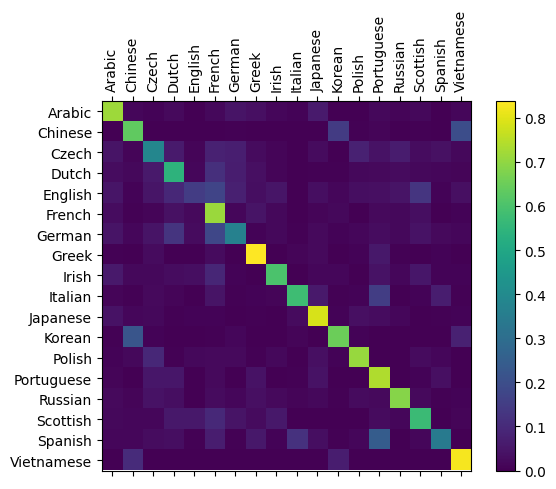

In [45]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Скорость обучения 0.001

Обучение
--------------------




In [46]:
criterion = nn.NLLLoss()

In [47]:
learning_rate = 0.001

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Теперь нам просто нужно запустить это с кучей примеров. Поскольку функция
`train` возвращает как результат, так и список ошибки, мы можем распечатать ее
предсказание, а также отслеживатьошибку для построения графика. Поскольку существует 1000
примеров, мы печатаем только все примеры `print_every` и берем
среднее значение потерь.

In [48]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 0.5634 Magro / Italian ✓
10000 10% (0m 14s) 2.2870 Ozu / Korean ✗ (Japanese)
15000 15% (0m 21s) 0.6239 Serafim / Portuguese ✓
20000 20% (0m 29s) 0.3478 Kirchner / German ✓
25000 25% (0m 36s) 0.2319 Piontek / Polish ✓
30000 30% (0m 43s) 0.7385 Prchal / Czech ✓
35000 35% (0m 50s) 0.8675 Yin / Korean ✗ (Chinese)
40000 40% (0m 57s) 2.9295 Fernyhough / German ✗ (English)
45000 45% (1m 4s) 1.1033 Wiater / Polish ✓
50000 50% (1m 11s) 0.0214 Gwozdek / Polish ✓
55000 55% (1m 18s) 2.5530 Calligaris / Spanish ✗ (Italian)
60000 60% (1m 25s) 6.9284 Gross / Arabic ✗ (Russian)
65000 65% (1m 33s) 0.5105 Severins / Dutch ✓
70000 70% (1m 40s) 3.4531 Lind / Chinese ✗ (Czech)
75000 75% (1m 47s) 1.5976 Matos / Greek ✗ (Portuguese)
80000 80% (1m 54s) 0.1076 Czajka / Polish ✓
85000 85% (2m 1s) 0.4226 Wasem / Arabic ✓
90000 90% (2m 10s) 0.5894 Kalogeria / Greek ✓
95000 95% (2m 17s) 3.1707 Masson / Scottish ✗ (French)
100000 100% (2m 24s) 0.0097 Bouloukos / Greek ✓


Построение графика результатов
--------------------

Построение графика исторических потерь из `all_losses` показывает
обучение сети:

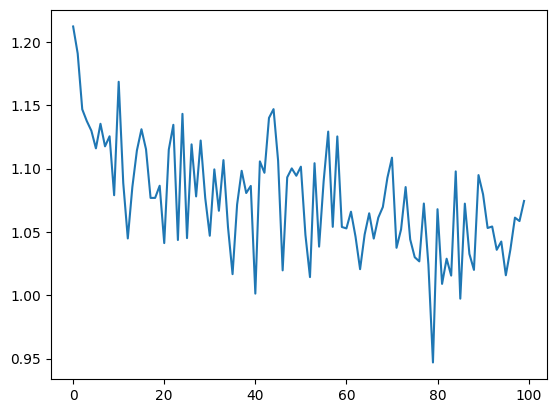

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Оценка результатов

Чтобы увидеть, насколько хорошо сеть работает с различными категориями, мы
создадим матрицу путаницы, указывающую для каждого фактического языка (строк)
какой язык угадывает сеть (столбцы). Чтобы рассчитать матрицу путаницы
, по сети выполняется множество выборок с
`evaluate()`, что то же самое, что `train()` за вычетом обратного распространения ошибки.


<ipython-input-50-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-50-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


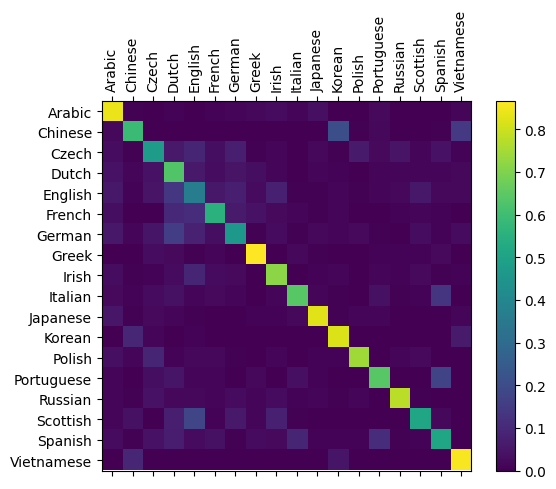

In [50]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Скорость обучения 0.01

Обучение
--------------------




In [51]:
criterion = nn.NLLLoss()

In [52]:
learning_rate = 0.01

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Теперь нам просто нужно запустить это с кучей примеров. Поскольку функция
`train` возвращает как результат, так и список ошибки, мы можем распечатать ее
предсказание, а также отслеживатьошибку для построения графика. Поскольку существует 1000
примеров, мы печатаем только все примеры `print_every` и берем
среднее значение потерь.

In [53]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.0165 Fraser / German ✗ (Scottish)
10000 10% (0m 14s) 3.0015 Rog / Korean ✗ (Polish)
15000 15% (0m 22s) 0.9701 Nifterick / Dutch ✓
20000 20% (0m 28s) 0.8065 Marek / Polish ✓
25000 25% (0m 36s) 0.8029 Cuan / Chinese ✓
30000 30% (0m 43s) 1.0061 Lenz / German ✓
35000 35% (0m 50s) 0.4729 Serafim / Portuguese ✓
40000 40% (0m 57s) 0.4469 Antar / Arabic ✓
45000 45% (1m 5s) 1.0873 Ocasek / Czech ✓
50000 50% (1m 12s) 1.0742 Holtzer / Czech ✗ (German)
55000 55% (1m 19s) 2.1436 Nana / Korean ✗ (Italian)
60000 60% (1m 26s) 1.0199 Kouri / Japanese ✗ (Arabic)
65000 65% (1m 36s) 0.0062 Babahanov / Russian ✓
70000 70% (1m 43s) 1.5016 Byrne / Scottish ✗ (English)
75000 75% (1m 51s) 0.0177 Pispinis / Greek ✓
80000 80% (1m 57s) 0.0030 Galanopoulos / Greek ✓
85000 85% (2m 5s) 0.5077 Almeida / Portuguese ✓
90000 90% (2m 12s) 0.2592 Jo / Korean ✓
95000 95% (2m 19s) 0.0501 Matsukata / Japanese ✓
100000 100% (2m 26s) 1.1360 Auttenberg / Polish ✓


Построение графика результатов
--------------------

Построение графика исторических потерь из `all_losses` показывает
обучение сети:

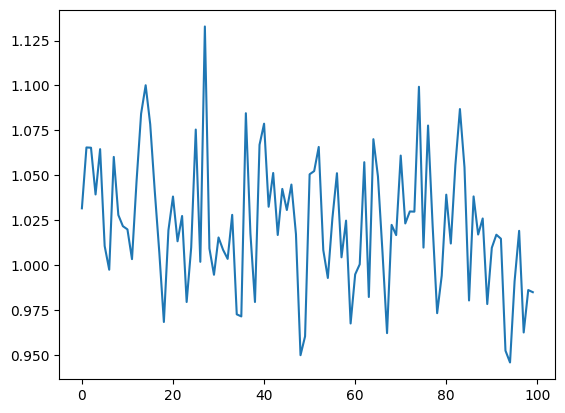

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Оценка результатов

Чтобы увидеть, насколько хорошо сеть работает с различными категориями, мы
создадим матрицу путаницы, указывающую для каждого фактического языка (строк)
какой язык угадывает сеть (столбцы). Чтобы рассчитать матрицу путаницы
, по сети выполняется множество выборок с
`evaluate()`, что то же самое, что `train()` за вычетом обратного распространения ошибки.


<ipython-input-55-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-55-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


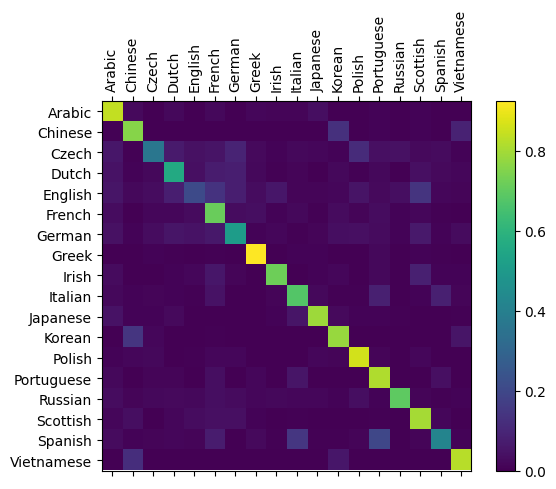

In [55]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

наилучшая скорость 0.005